In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

from models import MDRE


N_DIMS = 1 # Number of dimensions
NUM_SAMPLES = 10 # Number of samples per distribution (if 3 distributions, then 3 x 33000)
BS = 64 # Batch size
NUM_EPOCHS = 500 # Number of epochs
SEED = 44
GAMMA = 1 / 3
tkwargs = {"device": "cpu", "dtype": torch.float64}

In [2]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def forrester(x, noise=False):
#     f = (6*x - 2)**2 * np.sin(3*x - 4)
    f = np.sin(3*x) + x**2 - 0.7*x + 1
    if noise:
        f += np.random.normal(0, .2, f.shape)
    return f

In [4]:
dense_x = np.linspace(-1, 2, 1024).reshape(-1, 1)
dense_y = forrester(dense_x, noise=False)

In [5]:
X_obs = np.random.uniform(-1, 2, (10, 1))
y_obs = forrester(X_obs, noise=True)
tau = np.quantile(y_obs, q=GAMMA)

In [6]:
from botorch.utils.sampling import draw_sobol_samples
from sklearn.neighbors import KernelDensity
from scipy import interpolate

def kde_sampling(X_obs, num_samples):
    kde = KernelDensity(
#         bandwidth=0.1,
        bandwidth="silverman",
        algorithm="auto",
        kernel="gaussian",
        metric="euclidean",
    ).fit(X_obs)
    dense_x = np.linspace(-1, 2, 1024).reshape(-1, 1)
    density_obs = np.exp(kde.score_samples(dense_x))
    inv_density = np.exp(- kde.score_samples(dense_x))
    # unnormalized pdf
    pdf = inv_density
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf.max()
    inverse_cdf = interpolate.interp1d(cdf, dense_x[:, 0])
    x_samples = inverse_cdf(np.random.uniform(0, 1, (num_samples, 1)))
    return torch.from_numpy(x_samples)
    

def rejection_sampling(model, bounds, num_samples):
    x_samples = torch.empty(0, bounds.size(1))
    while len(x_samples) < 1:
        samples_uniform_x = torch.rand(num_samples, bounds.size(1))
        samples_uniform_x = samples_uniform_x * (bounds[1] - bounds[0]) + bounds[0]
        samples_uniform_y = torch.rand(num_samples)

        samples_uniform_x, samples_uniform_y = samples_uniform_x.to(**tkwargs), samples_uniform_y.to(**tkwargs)
        mdre_preds = model.predict(samples_uniform_x)
        prob_mdre = torch.nn.functional.softmax(mdre_preds, dim=-1) + 0.2
        rj_idx = samples_uniform_y <= prob_mdre[:, 2]
        x_samples = torch.concat([x_samples, samples_uniform_x[rj_idx]])

    return x_samples

def prepare_data_mdre(X, y, gamma, mdre):
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    tau = torch.quantile(y, q=gamma)
    z = torch.less(y, tau)

    x_p, y_p = X[z.squeeze()], y[z.squeeze()]
    w_p = (tau - y)[z]
    w_p = w_p / torch.mean(w_p)

    x_q, y_q = X, y
#     x_m = kde_sampling(X, num_samples=len(X))
#     x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]]), n=len(X), q=1).squeeze(1)
    x_m = rejection_sampling(mdre, bounds=torch.tensor([[-1.], [2.]]), num_samples=len(X))
    x = torch.cat([x_p, x_q, x_m], axis=0)

    z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)
    z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)
    z_m = torch.empty(x_m.shape[0], dtype=torch.long).fill_(2)
    z = torch.cat([z_p, z_q, z_m], axis=0)
    z_onehot = torch.nn.functional.one_hot(z).to(X.dtype)

    s_p = x_p.shape[0]
    s_q = x_q.shape[0]
    s_m = x_m.shape[0]

    w_p = w_p * (s_p + s_q + s_m) / s_p
    w_q = z_q * (s_p + s_q + s_m) / s_q
    w_m = torch.tensor(len(z_m) * [ (s_q + s_p + s_m) / s_m]).to(X.dtype)
    w = torch.cat([w_p, w_q, w_m], axis=0)
    w = w / w.mean()

    return x, z_onehot, w, tau

In [7]:
def plot_step_through_mdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs[:, 0].bool()]
    y_p = y_obs[z_obs[:, 0].bool()]
    x_q = X_obs[z_obs[:, 1].bool()]
    y_q = y_obs[z_obs[:, 1].bool()]
    x_m = X_obs[z_obs[:, 2].bool()]
    
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.scatter(dense_x, acf[:, 0], s=1, color='tab:red',)
    ax_func.scatter(dense_x, acf[:, 1], s=1, color='tab:blue',)
    ax_func.scatter(dense_x, acf[:, 2], s=1, color='tab:green',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('MDRE')

#     ax_func.plot(
#         x_p,
#         np.zeros(len(x_p)),
#         '|',
#         markersize=12,
#         color="tab:red"
#     )
#     ax_func.plot(
#         x_q,
#         np.zeros(len(x_q)),
#         '|',
#         markersize=12,
#         color="tab:blue"
#     )
    ax_func.plot(
        x_m,
        np.zeros(len(x_m)),
        '|',
        markersize=12,
        color="tab:green"
    )

    ax_acf.fill_between(
        dense_x.flatten(),
        dr,
        0,
        facecolor="#2ca02c3f",
        edgecolor="#2ca02c",
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


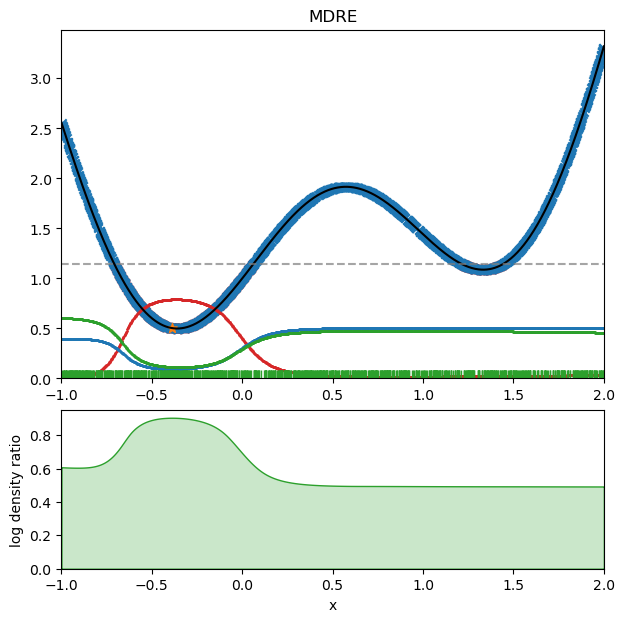

In [8]:
X_obs = np.random.uniform(-1, 2, (2048, 1))
y_obs = forrester(X_obs, noise=False)

X_obs_mdre, y_obs_mdre = X_obs, y_obs

num_evaluations = 1

mdre = MDRE(input_dim=1, output_dim=3, **tkwargs)
for n in range(num_evaluations):
    
    fig = plt.figure(figsize=(7, 7))
    ax_func_mdre = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax_acf_mdre = plt.subplot2grid((3, 1), (2, 0), rowspan=1)

    # mdre
    X_train_mdre, z_train_mdre, weight, tau = prepare_data_mdre(X_obs_mdre, y_obs_mdre, gamma=GAMMA, mdre=mdre)
#     if n > 0:
    mdre = MDRE(input_dim=1, output_dim=3, **tkwargs)
    y_train_mdre = forrester(X_train_mdre)
    mdre.fit(X_train_mdre, z_train_mdre, weight, S=1000)
    mdre_preds = mdre.predict(torch.from_numpy(dense_x))
    acf_mdre = torch.nn.functional.softmax(mdre_preds, dim=-1).numpy()
    dr_mdre = 1 - acf_mdre[:, 1]
#     dr_mdre = (np.log(acf_mdre[:, 0]) - np.log(acf_mdre[:, 1]))
    new_x = dense_x[np.argmax(dr_mdre)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_mdre(X_train_mdre, y_train_mdre, z_train_mdre, new_x, new_y, tau, dr_mdre, acf_mdre, ax_func_mdre, ax_acf_mdre)
    X_obs_mdre = np.concatenate([X_obs_mdre, new_x.reshape(-1, 1)])
    y_obs_mdre = np.concatenate([y_obs_mdre, new_y.reshape(-1, 1)])

    plt.show()

In [9]:
# kde = KernelDensity(
#     bandwidth=0.1,
#     algorithm="auto",
#     kernel="gaussian",
#     metric="euclidean",
# ).fit(X_obs_mdre)
# dense_x = np.linspace(-1, 2, 1024).reshape(-1, 1)
# density_obs = np.exp(kde.score_samples(dense_x))
# inv_density = np.exp(- kde.score_samples(dense_x))
# # unnormalized pdf
# pdf = inv_density
# cdf = np.cumsum(pdf)
# cdf = cdf / cdf.max()
# inverse_cdf = interpolate.interp1d(cdf, dense_x[:, 0])
# x_samples = inverse_cdf(np.random.uniform(0, 1, (10, 1)))

In [10]:
# plt.scatter(dense_x, density_obs, s=1)
# plt.scatter(dense_x, inv_density, s=1)

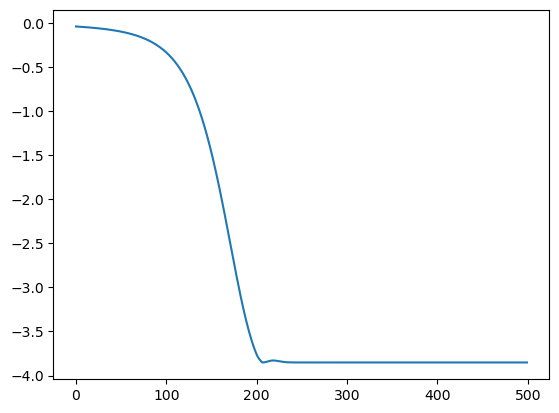

In [11]:
x = torch.tensor([-1], dtype=torch.float64, requires_grad=True)
optimizer = torch.optim.Adam([x])

losses = []
for epochs in range(500):
    optimizer.zero_grad()

    logits = mdre.clf(x)
    prob_p = torch.nn.functional.softmax(logits, dim=-1)[0]

    # We now have dloss/dx
    first_derivative = torch.autograd.grad(prob_p, x, create_graph=True)[0]
    first_derivative_abs =  - torch.abs(first_derivative)
    # This computes d/dx(dloss/dx) = d2loss/dx2
#     second_derivative = torch.autograd.grad(first_derivative_abs, x, create_graph=True)[0]

    first_derivative_abs.backward()
    optimizer.step()
    losses.append(first_derivative_abs.item())
plt.plot(losses)

In [12]:
first_derivative_abs

tensor([-3.8518], dtype=torch.float64, grad_fn=<NegBackward0>)

In [13]:
from scipy.optimize import minimize

def func(x):
    x = torch.tensor(x, requires_grad=True)
    logits = mdre.clf(x)
    prob_p = torch.nn.functional.softmax(logits, dim=-1)[0]

    # We now have dloss/dx
    first_derivative = torch.autograd.grad(prob_p, x, create_graph=True)[0]
    first_derivative_abs =  - torch.abs(first_derivative)
    second_derivative = torch.autograd.grad(first_derivative_abs, x, create_graph=True)[0]
    return first_derivative_abs.detach().numpy(), second_derivative.detach().numpy()

x_starts = np.random.uniform(-1, 2, (10))
results_x = []
results_fun = []
for x0 in x_starts:
    res = minimize(
        fun=func,
        x0=x0,
        args=(),
        method="L-BFGS-B",
        jac=True,
        bounds=[(-1, 2)],
    )
    results_x.append(res.x)
    results_fun.append(-res.fun)

estimated_L = np.max(results_fun)
L_loc = results_x[np.argmax(results_fun)]

In [14]:
def get_intercept_pos(x, estimated_L):
    x = torch.tensor(x, dtype=torch.float64)
    with torch.no_grad():
        logits = mdre.clf(x)
#     prob_p = torch.nn.functional.softmax(logits, dim=-1)[0]
#     first_derivative = torch.autograd.grad(prob_p, x, create_graph=True)[0]
    b = prob_p.detach().item() - estimated_L * x.detach().item()
    return b

def get_intercept_neg(x, estimated_L):
    x = torch.tensor(x, dtype=torch.float64)
    with torch.no_grad():
        logits = mdre.clf(x)
#     prob_p = torch.nn.functional.softmax(logits, dim=-1)[0]
#     first_derivative = torch.autograd.grad(prob_p, x, create_graph=True)[0]
    b = prob_p.detach().item() + estimated_L * x.detach().item()
    return b

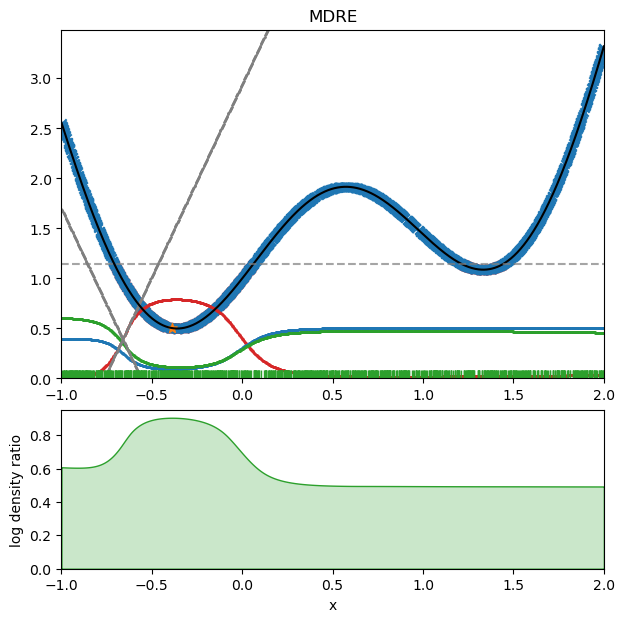

In [15]:
fig = plt.figure(figsize=(7, 7))
ax_func_mdre = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax_acf_mdre = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
plot_step_through_mdre(X_train_mdre, y_train_mdre, z_train_mdre, new_x, new_y, tau, dr_mdre, acf_mdre, ax_func_mdre, ax_acf_mdre)

b_pos = get_intercept_pos(L_loc, estimated_L)
b_neg = get_intercept_neg(L_loc, estimated_L)
ax_func_mdre.scatter(dense_x, estimated_L * dense_x + b_pos, s=1, color='tab:gray')
ax_func_mdre.scatter(dense_x, -estimated_L * dense_x + b_neg, s=1, color='tab:gray')